In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import cv2
import numpy as np
from pickle import dump
from pickle import load
import glob
import time
import configparser as cp

%matplotlib inline


In [2]:
# Get feature and model File names from saved config file
file_config = cp.ConfigParser()
configs = file_config.read('Project 5 - file_locations.ini')
svc_filename = file_config.get('file_locations', 'svc_filename')
car_features_filename = file_config.get('file_locations', 'car_features_filename')
no_car_features_filename = file_config.get('file_locations', 'no_car_features_filename')

## Functions

### Misc. Functions

In [3]:
# Function to get training images
def get_train_data():
    images = glob.glob('data/*/*/*.png', recursive=True)
    cars = []
    notcars = []
    for image in images:
        if 'non-vehicles' in image:
            notcars.append(image)
        else:
            cars.append(image)

    return cars, notcars


def display_images(img, cmap=None):
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 1, 1)    
#     plt.axis('off')
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    


### Feature Extractions Functions

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, transform_sqrt=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm='L2-Hys', 
                                  transform_sqrt=transform_sqrt, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm='L2-Hys',
                       transform_sqrt=transform_sqrt, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# def color_hist(img, nbins=32, bins_range=(0, 256)):
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    transform_sqrt=True  # we will set this false if color space = LUV or YUV
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Hog function can cause error in YUV or LUV color spaces
            if color_space == 'LUV' or color_space == 'YUV' :
                transform_sqrt=False
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':                
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True, transform_sqrt=transform_sqrt))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True, transform_sqrt=transform_sqrt)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Feature Prediction Functions

In [76]:

# Define a single function that can extract features using hog sub-sampling and make predictions
# Return image
def find_cars_img(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img


# Define a single function that can extract features using hog sub-sampling and make predictions
# Return list of boxes
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all=False):
    
    car_boxes = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    print(nblocks_per_window)
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(nxsteps):
        
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)            
            
            if test_prediction == 1 or show_all:
                
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)               
                car_boxes.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart)))
    return car_boxes

In [77]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))        
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [78]:

# Parameters for model
svc = load(open(svc_filename, 'rb'))
car_features = load(open(car_features_filename, 'rb'))
notcar_features = load(open(no_car_features_filename, 'rb'))

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Parameters for feature extraction
pix_per_cell = 16
cell_per_block = 2 # HOG cells per block
orient = 9
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [83]:
test_images = glob.glob('test_images/*.jpg')

zone1 ={'start':400, 'stop':500, 'xstart':0, 'xstop':1280, 'scale':1} 
zone2 ={'start':400, 'stop':550, 'xstart':0, 'xstop':1280, 'scale':1.5}  
zone3 ={'start':500, 'stop':600, 'xstart':0, 'xstop':1280, 'scale':2} 


# Image process pipeline
def image_process(image):
    box_list = []  # store detected boxes
   
#     out_img = find_cars(image, zone1['start'], zone1['stop'], zone1['xstart'], zone1['xstop'], zone1['scale'], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, True)
#     box_list.append(out_img)
    
#     out_img = find_cars(image, zone2['start'], zone2['stop'], zone2['xstart'], zone2['xstop'], zone2['scale'], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, True)
#     box_list.append(out_img)
    
    out_img = find_cars(image, zone3['start'], zone3['stop'], zone3['xstart'], zone3['xstop'], zone3['scale'], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, True)
    box_list.append(out_img)
       
    boxes = [box for sub_box_list in box_list for box in sub_box_list]    
    print(boxes)
    window_img = draw_boxes(image, boxes, color=(0, 0, 255), thick=6)
    
    display_images(window_img)
    

3
[]
3
[]
3
[]
3
[]
3
[]
3
[]


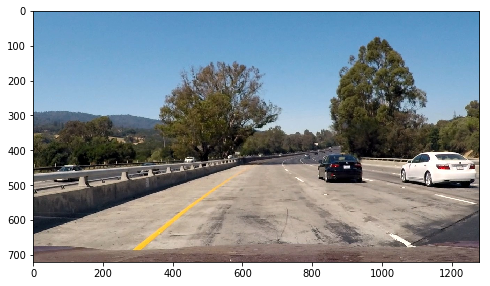

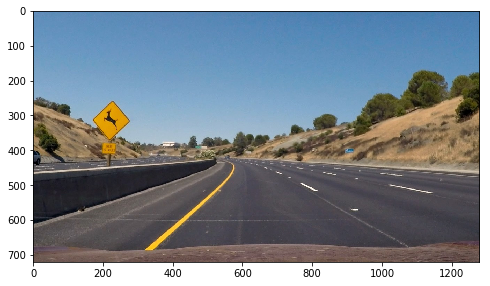

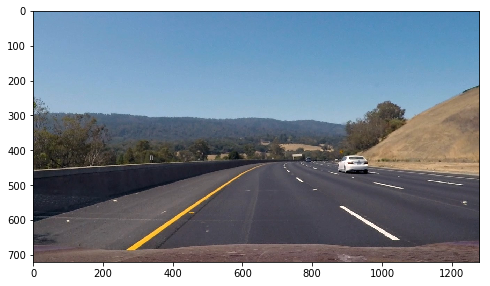

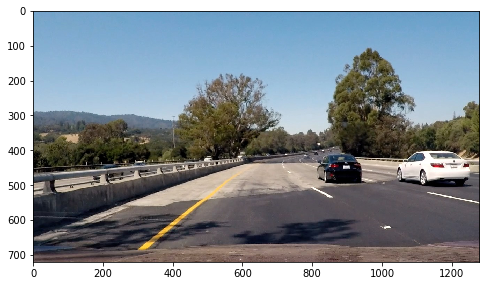

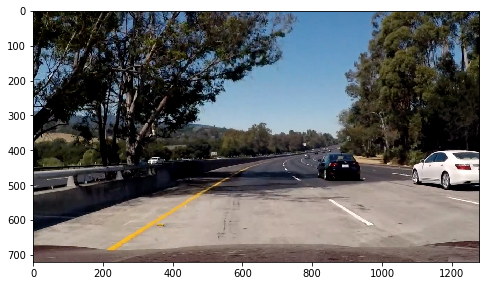

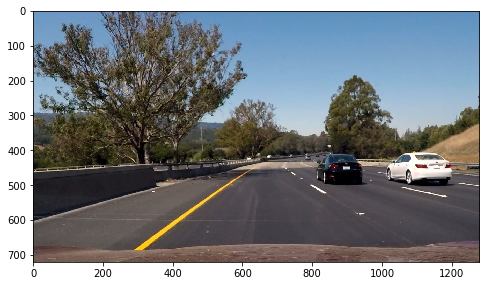

In [84]:
for img in test_images:
    image = mpimg.imread(img)
    image_process(image)

In [10]:
test_images = glob.glob('test_images/*.jpg')

zone1 ={'start':400, 'stop':500, 'xstart':480, 'xstop':1280, 'scale':1} 
zone2 ={'start':400, 'stop':550, 'xstart':550, 'xstop':1280, 'scale':1.5}  
zone3 ={'start':500, 'stop':650, 'xstart':550, 'xstop':1280, 'scale':2} 


# Image process pipeline
def image_process(image):
    box_list = []  # store detected boxes
   
    out_img = find_cars(image, zone1['start'], zone1['stop'], zone1['xstart'], zone1['xstop'], zone1['scale'], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list.append(out_img)
    
    out_img = find_cars(image, zone2['start'], zone2['stop'], zone2['xstart'], zone2['xstop'], zone2['scale'], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list.append(out_img)
    
    out_img = find_cars(image, zone3['start'], zone3['stop'], zone3['xstart'], zone3['xstop'], zone3['scale'], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list.append(out_img)
       
    boxes = [box for sub_box_list in box_list for box in sub_box_list]    
    
    window_img = draw_boxes(image, boxes, color=(0, 0, 255), thick=6)
    
    display_images(window_img)
    

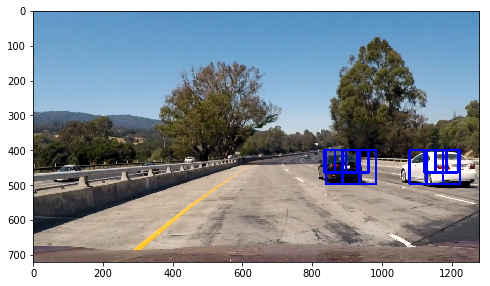

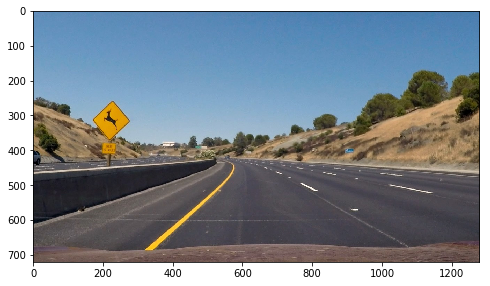

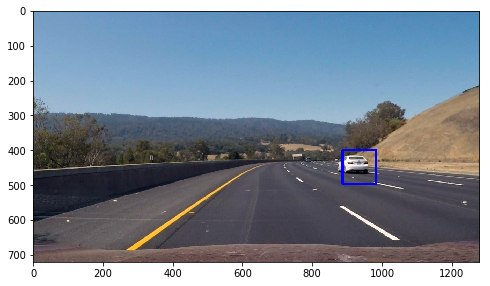

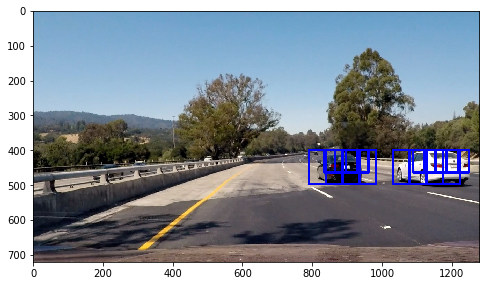

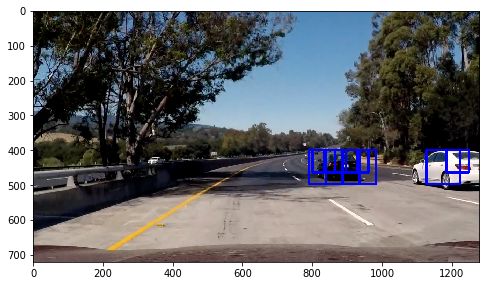

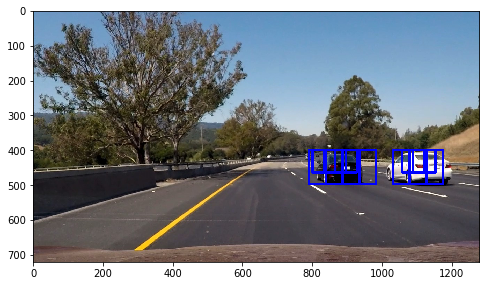

In [11]:
for img in test_images:
    image = mpimg.imread(img)
    image_process(image)